# Final Project - Zhengyang Kris Weng Submission 12/10/2024

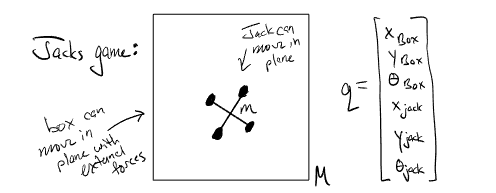

two bodies, six degrees of freedom, includes impacts, has external forces (for shaking the cup),
and is planar

In [26]:
import sympy as sym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go

In [27]:
def TransToRp(T):
    """Converts a homogeneous transformation matrix into a rotation matrix
    and position vector

    :param T: A homogeneous transformation matrix
    :return R: The corresponding rotation matrix,
    :return p: The corresponding position vector.

    Example Input:
        T = np.array([[1, 0,  0, 0],
                      [0, 0, -1, 0],
                      [0, 1,  0, 3],
                      [0, 0,  0, 1]])
    Output:
        (np.array([[1, 0,  0],
                   [0, 0, -1],
                   [0, 1,  0]]),
         np.array([0, 0, 3]))
    """
    R = T[:3, :3]
    p = T[:3, 3]
    return R, p


def TransInv(T):
    """Inverts a homogeneous transformation matrix

    :param T: A homogeneous transformation matrix
    :return: The inverse of T
    Uses the structure of transformation matrices to avoid taking a matrix
    inverse, for efficiency.

    Example input:
        T = np.array([[1, 0,  0, 0],
                      [0, 0, -1, 0],
                      [0, 1,  0, 3],
                      [0, 0,  0, 1]])
    Output:
        np.array([[1,  0, 0,  0],
                  [0,  0, 1, -3],
                  [0, -1, 0,  0],
                  [0,  0, 0,  1]])
    """
    R, p = TransToRp(T)
    Rt = R.T
    return sym.Matrix.vstack(sym.Matrix.hstack(Rt, -Rt * p), sym.Matrix([[0, 0, 0, 1]]))
    
def se3ToVec(se3mat):
    """ Converts an se3 matrix into a spatial velocity vector

    :param se3mat: A 4x4 matrix in se3
    :return: The spatial velocity 6-vector corresponding to se3mat

    Example Input:
        se3mat = np.array([[ 0, -3,  2, 4],
                           [ 3,  0, -1, 5],
                           [-2,  1,  0, 6],
                           [ 0,  0,  0, 0]])
    Output:
        np.array([1, 2, 3, 4, 5, 6])
    """
    return sym.Matrix([se3mat[2, 1], se3mat[0, 2], se3mat[1, 0], se3mat[0, 3], se3mat[1, 3], se3mat[2, 3]])

In [28]:
# Declare variables
t, m, M, g, l, L = sym.symbols('t m M g l L')
x_box = sym.Function('x_box')(t)
y_box = sym.Function('y_box')(t)
theta_box = sym.Function('theta_box')(t)
x_jack = sym.Function('x_jack')(t)
y_jack = sym.Function('y_jack')(t)
theta_jack = sym.Function('theta_jack')(t)

q = sym.Matrix([x_box, y_box, theta_box, x_jack, y_jack, theta_jack])
qdot = q.diff(t)
qddot = qdot.diff(t)

In [29]:
# Transformations

# world to box
g_w_b = sym.Matrix([[sym.cos(theta_box), -sym.sin(theta_box), 0, x_box], [sym.sin(theta_box), sym.cos(theta_box), 0, y_box], [0, 0, 1, 0], [0, 0, 0, 1]])
g_b_b1 = sym.Matrix([[1, 0, 0, L], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
g_b_b2 = sym.Matrix([[1, 0, 0, 0], [0, 1, 0, -L], [0, 0, 1, 0], [0, 0, 0, 1]])
g_b_b3 = sym.Matrix([[1, 0, 0, -L], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
g_b_b4 = sym.Matrix([[1, 0, 0, 0], [0, 1, 0, L], [0, 0, 1, 0], [0, 0, 0, 1]])

# world to jack
g_w_j = sym.Matrix([[sym.cos(theta_jack), -sym.sin(theta_jack), 0, x_jack], [sym.sin(theta_jack), sym.cos(theta_jack), 0, y_jack], [0, 0, 1, 0], [0, 0, 0, 1]])
g_j_j1 = sym.Matrix([[1, 0, 0, l], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
g_j_j2 = sym.Matrix([[1, 0, 0, 0], [0, 1, 0, -l], [0, 0, 1, 0], [0, 0, 0, 1]])
g_j_j3 = sym.Matrix([[1, 0, 0, -l], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
g_j_j4 = sym.Matrix([[1, 0, 0, 0], [0, 1, 0, l], [0, 0, 1, 0], [0, 0, 0, 1]])

# world to box sides
g_w_b1 = g_w_b * g_b_b1
g_w_b2 = g_w_b * g_b_b2
g_w_b3 = g_w_b * g_b_b3
g_w_b4 = g_w_b * g_b_b4

# world to jack ends
g_w_j1 = g_w_j * g_j_j1
g_w_j2 = g_w_j * g_j_j2
g_w_j3 = g_w_j * g_j_j3
g_w_j4 = g_w_j * g_j_j4

In [30]:
# impact relations
g_w_b_list = [g_w_b1, g_w_b2, g_w_b3, g_w_b4]
g_w_j_list = [g_w_j1, g_w_j2, g_w_j3, g_w_j4]

g_b_j = [[TransInv(g_w_b) * g_w_j for g_w_j in g_w_j_list] for g_w_b in g_w_b_list]
# display(g_b_j)

# Velocity
v_box = se3ToVec(np.array(TransInv(g_w_b) * g_w_b.diff(t)))
v_jack = se3ToVec(np.array(TransInv(g_w_j) * g_w_j.diff(t)))

j_jack = 4*(m/4)*l**2
j_box = 4*(M/4)*L**2
# display(j_box)

I_box = sym.Matrix([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, j_box, 0, 0, 0],
                    [0, 0, 0, M, 0, 0],
                    [0, 0, 0, 0, M, 0],
                    [0, 0, 0, 0, 0, M]])
I_jack = sym.Matrix([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, j_jack, 0, 0, 0],
                    [0, 0, 0, m, 0, 0],
                    [0, 0, 0, 0, m, 0],
                    [0, 0, 0, 0, 0, m]])

# Kinetic energy
T_box = 0.5 * v_box.dot(I_box * v_box)
T_jack = 0.5 * v_jack.dot(I_jack * v_jack)

KE = T_box + T_jack

# Potential Energy
PE = m*g*y_jack + M*g*y_box

# Calculate the Lagrangian:
L = KE.simplify() - PE.simplify()
print("EL Equation:")
display(L)


EL Equation:


0.5*L**2*M*Derivative(theta_box(t), t)**2 + 0.5*M*Derivative(x_box(t), t)**2 + 0.5*M*Derivative(y_box(t), t)**2 - g*(M*y_box(t) + m*y_jack(t)) + 0.5*l**2*m*Derivative(theta_jack(t), t)**2 + 0.5*m*Derivative(x_jack(t), t)**2 + 0.5*m*Derivative(y_jack(t), t)**2

In [31]:
# EL equations
dLdq = sym.Matrix([L]).jacobian(q).T
dLdqdot = sym.Matrix([L]).jacobian(qdot).T
dLdqdotdt = dLdqdot.diff(t)

# Let there be force
f_y_box = M*g
f_theta_box = 50*sym.sin(sym.pi*t)
F = sym.Matrix([0, f_y_box, f_theta_box, 0, 0, 0])

EL_lhs = dLdqdotdt - dLdq
EL_rhs = F
EL_lhs.simplify()
EL_rhs.simplify()
EL_eqn = sym.Eq(EL_lhs, EL_rhs)
display(EL_eqn)


# Solve
soln = sym.solve(EL_eqn, qddot, dict=True)
for sol in soln:
    print('\n\033[1mSymbolic Solution: ')
    for v in qddot:
        display(sym.Eq(v, sol[v].simplify()))

Eq(Matrix([
[          1.0*M*Derivative(x_box(t), (t, 2))],
[    M*(g + 1.0*Derivative(y_box(t), (t, 2)))],
[ 1.0*L**2*M*Derivative(theta_box(t), (t, 2))],
[         1.0*m*Derivative(x_jack(t), (t, 2))],
[   m*(g + 1.0*Derivative(y_jack(t), (t, 2)))],
[1.0*l**2*m*Derivative(theta_jack(t), (t, 2))]]), Matrix([
[           0],
[         M*g],
[50*sin(pi*t)],
[           0],
[           0],
[           0]]))


Symbolic Solution: 


Eq(Derivative(x_box(t), (t, 2)), 0.0)

Eq(Derivative(y_box(t), (t, 2)), 0.0)

Eq(Derivative(theta_box(t), (t, 2)), 50.0*sin(3.14159265358979*t)/(L**2*M))

Eq(Derivative(x_jack(t), (t, 2)), 0.0)

Eq(Derivative(y_jack(t), (t, 2)), -g)

Eq(Derivative(theta_jack(t), (t, 2)), 0.0)